### Captcha Recognition v1 by g.kanavenko

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

data_dir = '/data1/datasets/capcha/'

for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/data1/datasets/capcha/images.npy
/data1/datasets/capcha/images_unlabeled.npy
/data1/datasets/capcha/labels.npy
/data1/datasets/capcha/images_sub.npy


Загрузим данные в массивы numpy.

In [2]:
import numpy as np
images = np.load(data_dir+'images.npy')
labels = np.load(data_dir+'labels.npy')
images_sub = np.load(data_dir+'images_sub.npy')
print(f'images: {images.shape} of type {images.dtype}')
print(f'labels: {labels.shape} of type {labels.dtype}')
print(f'images_sub: {images_sub.shape} of type {images_sub.dtype}')

num_classes = 26 #количество классов
img_shape = (48, 48, 3) #размер изображений

images: (20000, 48, 48, 3) of type uint8
labels: (20000,) of type int64
images_sub: (50000, 48, 48, 3) of type uint8


In [3]:
print(labels[:10])
print(images[0].shape)

[13 24  8 13 13 18 13 23  0 13]
(48, 48, 3)


Посмотрим, как выглядят изображения.

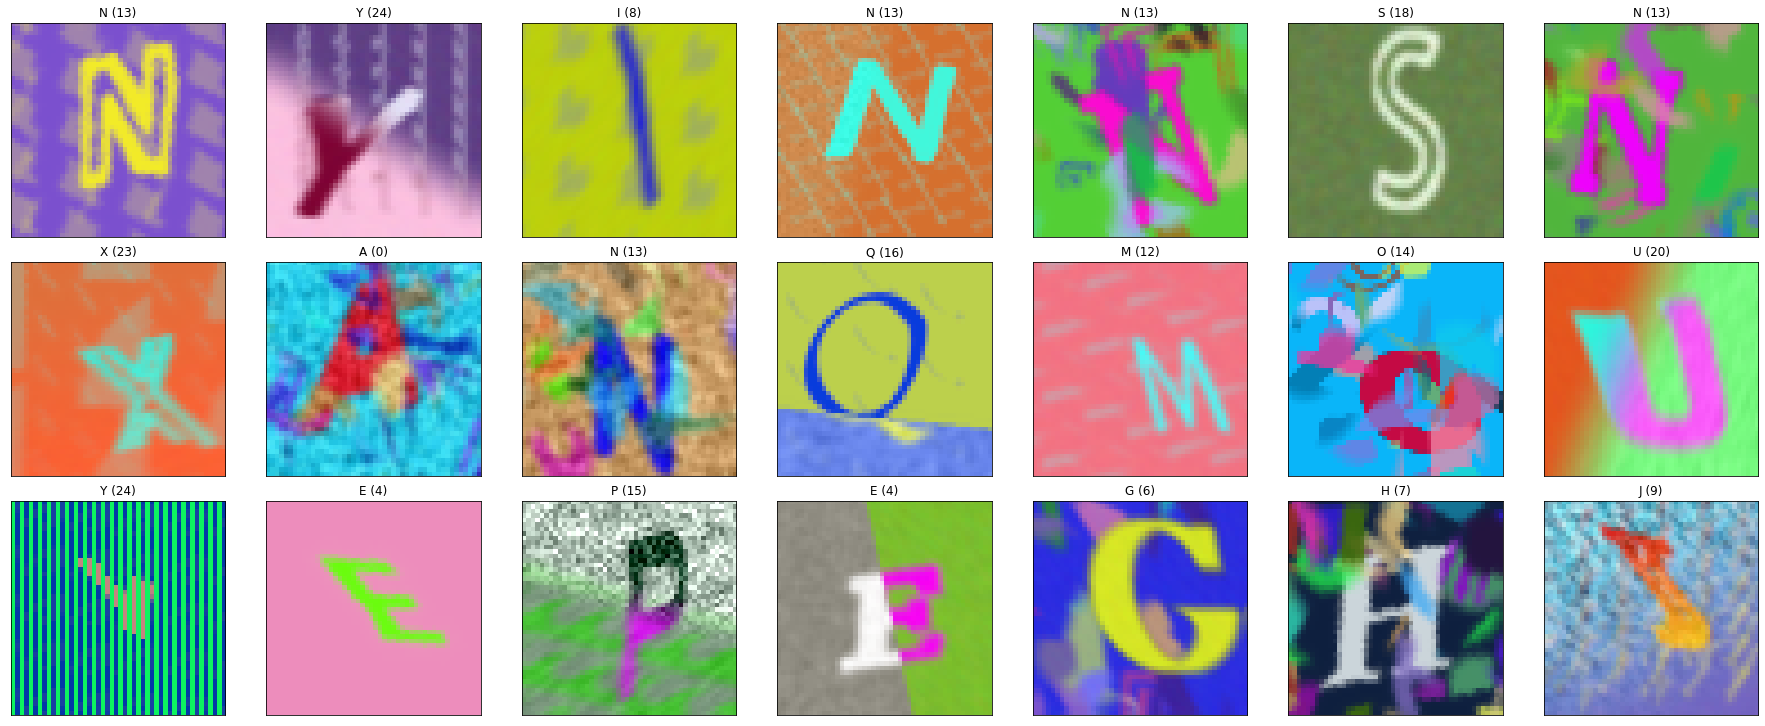

In [4]:
import matplotlib.pyplot as plt

def label_to_letter(label):
    return chr(ord('A') + label)

def show_symbols(images, labels = None, columns = 10, **kwargs):
    if labels is None: labels = [None] * len(images)
    rows = (len(images) - 1) // columns + 1
    fig = plt.figure(figsize = (25, (1.8 * 13 / columns) * rows))
    for i, (img, label) in enumerate(zip(images, labels)):
        ax = fig.add_subplot(rows, columns, i + 1)
        imshow_kwargs = {'vmin': 0, 'vmax': 255}
        imshow_kwargs.update(kwargs)
        ax.imshow(img, **imshow_kwargs)
        if label is not None: ax.set_title(label)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    fig.tight_layout(pad = 0.5)
    plt.show()

display_count = 7*3
show_symbols(
    images[:display_count],
    labels = [f'{label_to_letter(x)} ({x})' for x in labels[:display_count]],
    columns = 7
)

Посмотрим, как распределены классы в обучающих данных, а также посчитаем вероятность случайного угадывания класса.

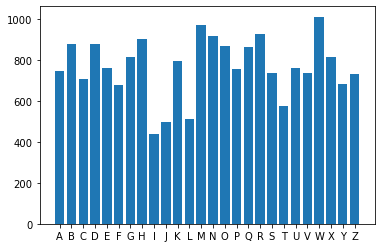

Вероятность случайного угадывания: 0.0385


In [5]:
import string
plt.bar(x = list(string.ascii_uppercase), height = np.bincount(labels));
plt.show()

print(f'Вероятность случайного угадывания: {1/num_classes:.4f}')

Не забудем нормализовать изображения, то есть перевести пиксели из диапазона от 0 до 255 в диапазон от 0 до 1, разделив массив на 255. Есть и другой вариант нормализации - перевод в диапазон от -1 до 1 (деление на 128 и вычитание единицы).

In [6]:
images_normalized = images / 255
images_sub_normalized = images_sub / 255

Теперь обучим модель MLP, то есть полносвязную сеть, и оценим ее точность.

In [7]:
import keras # Keras - библиотека для глубокого обучения
from IPython.display import clear_output

# нейронная сеть задается как последовательность слоев
model = keras.Sequential([
    keras.Input(shape = img_shape), # img_shape == (48, 48, 3)
    # слой Dense принимает одномерный вектор, а изображение трехмерно,
    # поэтому используем слой Flatten для перевода в 1-мерный вектор
    keras.layers.Flatten(),
    # скрытый слой из 1000 нейронов
    keras.layers.Dense(1000, activation = 'sigmoid'),
    # выходной слой из 26 нейронов, не забудем активацию 'softmax'
    keras.layers.Dense(num_classes, activation = 'softmax')
])

model.compile(
    # функция потерь для обучения нейронной сети
    loss = 'sparse_categorical_crossentropy',
    # оптимизатор, в качестве параметра принимает learning rate
    optimizer = keras.optimizers.Adam(1e-5),
    #дополнительная метрика - доля верно распознанных изображений
    metrics = 'accuracy'
)

Приступаем к обучению модели. Не забудьте включить GPU в настройках ноутбука, чтобы обучение шло быстрее (Accelerator -> GPU).

Обратите внимание, параметры `loss`, `optimizer`, `metrics` в функции `model.compile()`, а также параметр `activation` в слое `Dense` можно задавать как строками, так и классами, подробнее об этом рассказано в курсе.

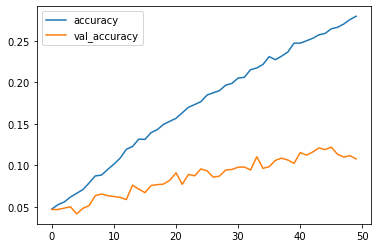

In [8]:
for epoch in range(50): # обучаем в течение 50 эпох (с GPU на обучение уйдет около 5 минут)
    history = model.fit(
        #данные для обучения - входные (нормализованные изображения) и целевые (метки классов)
        images_normalized, labels,
        #размер батча
        batch_size = 8,
        # мы не делим вручную данные на обучающие и валидационные, с параметром
        # validation_split метод .fit() делает это за нас
        validation_split = 0.15,
        # обучаем по одной эпохе (см. внешний цикл)
        epochs = 1,
        # этот параметр нужен, чтобы в течение обучения сохранялась метрики
        callbacks = ([model.history] if epoch > 0 else None)
    )
    # после каждой эпохи очищаем вывод ячейки и перерисовываем график точности
    clear_output(wait = True)
    plt.plot(history.history['accuracy'], label = 'accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.legend()
    plt.show()

График тренировочной точности полносвязной сети сильно опережает валидационную точность - это означает, что модель переобучилась. Точность на валидации едва превышает 10%, это не сильно много, но гораздо выше точности случайного угадывания.

Теперь обучим простую сверточную сеть и увидим разницу. В дальнейшем, изучая материал курса, вы сможете еще больше повысить точность.

In [13]:
# model = keras.Sequential([
#     keras.Input(shape = img_shape),
#     keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
#     keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
#     keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
#     keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Flatten(),
#     keras.layers.Dense(100, activation = 'relu'),
#     keras.layers.Dense(num_classes, activation = 'softmax')
# ])

# model.compile(
#     loss = 'sparse_categorical_crossentropy',
#     optimizer = keras.optimizers.Adam(1e-4),
#     metrics = 'accuracy'
# )

In [9]:
model = keras.Sequential([
    keras.Input(shape = img_shape),
    keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(.25),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(.25),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(.25),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(.5),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = keras.optimizers.Adam(1e-4),
    metrics = 'accuracy'
)

Мы будем обучать сверточную сеть в течение 20 эпох в качестве примера, хотя большее количество эпох дало бы еще более высокую точность. 

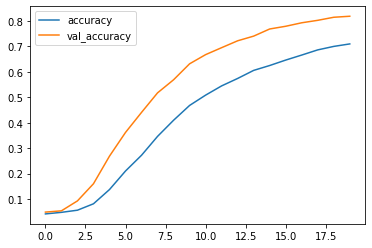

In [10]:
for epoch in range(20):
    history = model.fit(
        images_normalized, labels,
        batch_size = 8,
        validation_split = 0.15,
        epochs = 1,
        callbacks = ([model.history] if epoch > 0 else None)
    )
    clear_output(wait = True)
    plt.plot(history.history['accuracy'], label = 'accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.legend()
    plt.show()

Теперь сделаем предсказания сверточной сети на нормализованных sumbission-данных.

In [11]:
predictions = model.predict(images_sub_normalized)
print(predictions.shape)

1563/1563 [==============================] - 2s 1ms/step
(50000, 26)


Первая ось - номер изображения, вторая - номер класса, значения в массиве - вероятности. Нам осталось для каждого изображения найти класс, вероятность для которого наибольшая, для этого используем метод `argmax` для оси 1.

In [12]:
predictions = predictions.argmax(axis = 1)
print(predictions.shape)
print(predictions[:10]) # посмотрим первые 10 предсказаний

(50000,)
[18 11 14 12 10  7  5 17 23 22]


Теперь мы имеем массив из 50 тысяч предсказаний. Создаем файл `submission.csv`. Название файла не обязательно должно быть именно таким, главное - записать в него данные в нужном формате.

In [13]:
import pandas as pd
submission = pd.DataFrame()
submission['Id'] = list(range(len(predictions)))
submission['Category'] = predictions
submission.to_csv('submission.csv', index = False)

Мы не сможем узнать точность на submission-данных без загрузки файла с ответами на сайт. Файл `submission.csv` нужно загрузить на Kaggle. Это можно сделать либо скачав файл в панели управления справа и загрузив его кнопкой **Submit predictions** на странице соревнования, либо через опцию Save & Run All (Commit) в ноутбуке. В этом случае, когда ноутбук отработает до конца в бэкграунде, внизу в ноутбуке появится кнопка сабмита.

--------------

В последней ячейке покажем минималистичный пример полного цикла: загрузка данных, построение модели, обучение и сабмит.

In [ ]:
# import numpy as np
# import pandas as pd
# import keras
# from keras import *
# from keras.layers import *

# images = np.load('/kaggle/input/sf-captcha-recognition/data/images.npy') / 255
# labels = np.load('/kaggle/input/sf-captcha-recognition/data/labels.npy')
# images_sub = np.load('/kaggle/input/sf-captcha-recognition/data/images_sub.npy') / 255

# model = Sequential([ # замените на вашу модель
#     Flatten(input_shape = (48, 48, 3)),
#     Dense(26, activation = 'softmax')
# ])

# model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')
# model.fit(images, labels, batch_size = 8, validation_split = 0.1, epochs = 10)

# predictions = model.predict(images_sub).argmax(axis = 1)
# submission = pd.DataFrame({'Id': list(range(len(predictions))), 'Category': predictions})
# submission.to_csv('submission2.csv', index = False)